<img src="img.jpg">

# Workout Classification
Now it's possible to collect a large amount of data about personal movement using activity monitoring devices such as a [Fitbit](http://www.fitbit.com), [NikeFuelband](http://www.nike.com/us/en_us/c/nikeplus-fuelband), or [Jawbone Up](https://jawbone.com/up). These type of devices are part of the "quantified self" movement, a group of enthusiasts who take measurements about themselves regularly to improve their health or to find patterns in their behavior. Unfurtunatelly, these data remain under-utilized both because the raw data are hard to obtain and there is a lack of statistical methods and software for processing and interpreting the data.

Usually, people quantify the amount of exercise they do but don't the quality of it. The objective of this project is to use the data from accelerometers on the belt, forearm, arm, and dumbbell to classify when an exercise is done correctly or not.

This project is structured as follows:
1. [Understanding the Data](#Understanding_the_Data)
    1. [Descriptive and Exploratory Analysis](#Descriptive_and_Exploratory_Analysis)
        1. [Anomaly Detection](#Anomaly_Detection)
    2. [Training and Validation Dataset](#Training_and_Validation_Dataset)
2. [Feature Selection/Importance](#Feature_Selection_Importance)
3. [Classification Model](#Classification_Model)
4. [Conclusions and Remarks](#Conclusions_and_Remarks)

## Understanding the Data
<a id='Understanding_the_Data'></a>

This project is possible thanks to the data obtained from [here](http://groupware.les.inf.puc-rio.br/har#weight_lifting_exercises). Also, the owners of this dataset have an [available publication](http://groupware.les.inf.puc-rio.br/public/papers/2013.Velloso.QAR-WLE.pdf). 

The experimental design was conducted in accordance with the next points:
1. The exercises were performed by 6 young (20-28 years old) healthy participants.
2. Each participant did 10 repetitions of "Unilateral Dumbbell Biceps Curl" in 5 different fashions:
    1. _Class A_: Exactly as the specifications (high quality performance)
    2. _Class B_: Throwing the elbows to the front (mistake).
    3. _Class C_: Lifting the dumbbell only halfway (mistake).
    4. _Class D_: Lowering the dumbbell only halfway (mistake).
    5. _Class E_: Throwing the hips to the front (mistake).
3. Four sensors were used to collect the data (in the glove, armband, lumbar belt and dumbbell), as it is represented in the below figure (this figure was inspired by the schema proposed by the author [here](http://groupware.les.inf.puc-rio.br/public/papers/2013.Velloso.QAR-WLE.pdf)).
4. Each sensor acts as a center of a euclidean coordinates system, so, for each sensor was possible to record it's [intrinsic rotations](https://en.wikipedia.org/wiki/Euler_angles) (yaw, pitch, and roll), in addition to the [gyroscope](https://en.wikipedia.org/wiki/Gyroscope), [accelerometer](https://en.wikipedia.org/wiki/Accelerometer), and [magnetometer](https://en.wikipedia.org/wiki/Magnetometer) values for each axis of the coordinate system.
    
<img src="workout_body.png">

More details about this data can be consulted [here](http://groupware.les.inf.puc-rio.br/har#weight_lifting_exercises).

## Descriptive and Exploratory Analysis
<a id='Descriptive_and_Exploratory_Analysis'></a>

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *

In [4]:
# Load Dataset
raw_data=pd.read_csv('WearableComputing_weight_lifting_exercises_biceps_curl_variations.csv',low_memory=False)
# Make a copy of the data
curl_variation=raw_data.copy()
print('The dataset is composed by {} instances and {} features.'.format(
    curl_variation.shape[0],curl_variation.shape[1]))

The dataset is composed by 39242 instances and 159 features.


In [6]:
# Get some information about the dataset
curl_variation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39242 entries, 0 to 39241
Columns: 159 entries, user_name to classe
dtypes: float64(99), int64(23), object(37)
memory usage: 47.6+ MB


The target variable is `classe`, and as we can see below, there is a little imbalance between class A and the other classes that we need to take care of. Nevertheless, by the moment lets put the target variable out of the dataset.

In [3]:
# Count the categories frequency of the target variable
curl_variation['classe'].value_counts()

A    11159
B     7593
E     7214
C     6844
D     6432
Name: classe, dtype: int64

In [120]:
# Create the target and explanation dataset
y = curl_variation['classe']
X = curl_variation.drop(columns='classe')

Before going forward, lets split the dataset to create a test set that we only are going to use at the end of the analysis to prove the efficiency of the predictive algorithm. Because I want to keep the proportion of classes of the original dataset in the test data, I am not going to use the classical `train_test_split` method in sklearn, but the method `StratifiedShuffleSplit`.

In [121]:
# Create a test dataset
from sklearn.model_selection import StratifiedShuffleSplit
# Create an object StratifiedShuffleSplit
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# Create the training and testing dataset
for train_index, test_index in stratSplit.split(X, y):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
print('The training data is composed by {} observations and {} variables.'.format(X_train.shape[0],
                                                                                 X_train.shape[1]))
print('The test data is composed by {} observations and {} variables.'.format(X_test.shape[0],
                                                                                 X_test.shape[1]))

The training data is composed by 31393 observations and 158 variables.
The test data is composed by 7849 observations and 158 variables.


In all the following sections we are going to work only on the `X_train`, `y_train` dataset.

In [122]:
# Display the head of our data frame
pd.set_option('display.max_columns',None)
X_train.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,kurtosis_roll_belt,kurtosis_picth_belt,kurtosis_yaw_belt,skewness_roll_belt,skewness_roll_belt.1,skewness_yaw_belt,max_roll_belt,max_picth_belt,max_yaw_belt,min_roll_belt,min_pitch_belt,min_yaw_belt,amplitude_roll_belt,amplitude_pitch_belt,amplitude_yaw_belt,var_total_accel_belt,avg_roll_belt,stddev_roll_belt,var_roll_belt,avg_pitch_belt,stddev_pitch_belt,var_pitch_belt,avg_yaw_belt,stddev_yaw_belt,var_yaw_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,var_accel_arm,avg_roll_arm,stddev_roll_arm,var_roll_arm,avg_pitch_arm,stddev_pitch_arm,var_pitch_arm,avg_yaw_arm,stddev_yaw_arm,var_yaw_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,kurtosis_roll_arm,kurtosis_picth_arm,kurtosis_yaw_arm,skewness_roll_arm,skewness_pitch_arm,skewness_yaw_arm,max_roll_arm,max_picth_arm,max_yaw_arm,min_roll_arm,min_pitch_arm,min_yaw_arm,amplitude_roll_arm,amplitude_pitch_arm,amplitude_yaw_arm,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,kurtosis_roll_dumbbell,kurtosis_picth_dumbbell,kurtosis_yaw_dumbbell,skewness_roll_dumbbell,skewness_pitch_dumbbell,skewness_yaw_dumbbell,max_roll_dumbbell,max_picth_dumbbell,max_yaw_dumbbell,min_roll_dumbbell,min_pitch_dumbbell,min_yaw_dumbbell,amplitude_roll_dumbbell,amplitude_pitch_dumbbell,amplitude_yaw_dumbbell,total_accel_dumbbell,var_accel_dumbbell,avg_roll_dumbbell,stddev_roll_dumbbell,var_roll_dumbbell,avg_pitch_dumbbell,stddev_pitch_dumbbell,var_pitch_dumbbell,avg_yaw_dumbbell,stddev_yaw_dumbbell,var_yaw_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,kurtosis_roll_forearm,kurtosis_picth_forearm,kurtosis_yaw_forearm,skewness_roll_forearm,skewness_pitch_forearm,skewness_yaw_forearm,max_roll_forearm,max_picth_forearm,max_yaw_forearm,min_roll_forearm,min_pitch_forearm,min_yaw_forearm,amplitude_roll_forearm,amplitude_pitch_forearm,amplitude_yaw_forearm,total_accel_forearm,var_accel_forearm,avg_roll_forearm,stddev_roll_forearm,var_roll_forearm,avg_pitch_forearm,stddev_pitch_forearm,var_pitch_forearm,avg_yaw_forearm,stddev_yaw_forearm,var_yaw_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
25536,adelmo,1322832883,80342,02/12/2011 13:34,no,558,126.00,-41.90,162.0,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,0.13,-0.16,48,39,-158,167,600,-308,-14.4,38.0,-72.5,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.03,-0.67,0.87,-266,-48,-5,-260,300,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.950098,-29.278592,-97.734742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,0.21,0.15,-47,78,-135,-567.0,240.0,55.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.93,2.57,1.05,-165.0,433.0,-13,-537.0,765.0,699.0
28236,adelmo,1322832860,936360,02/12/2011 13:34,no,619,125.00,-42.80,166.0,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11,0.11,-0.16,49,45,-160,171,599,-314,-59.7,-78.7,55.1,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.06,-0.03,0.56,128,-134,-274,589,-149,-398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.514161,-28.563605,-108.194397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14,-0.02,0.00,-45,60,-141,-564.0,232.0,93.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN,NaN,NaN

If you explore the above table, you can see that a lot of variables have not assigned values at least in the first 5 instances. Therefore, let's see what is the average of NaN for each feature in our dataset and erase the variables with more than 40% of missing values.
> This threshold was selected taking into account that best algorithms/methods have a breaking point of 50%, this is, it's necessary at least 50% of the data in the distribution to make relative accurate estimations (for example the median). If we are going to impute the missing values, we need enough information in the variable, otherwise, it's better to drop the variable.

In [123]:
# Compute the average of rows with missing values per variable and only keep columns with 60%+ of information
pd.set_option('display.max_rows',None)
columns_out=X_train.columns[(X_train.isna().sum()/len(X_train)>0.4).values]
print('The {}% of the variables have more than 40% of the observations as NaN.'.format(
    round(100*len(columns_out)/X_train.shape[1],2)))

The 63.29% of the variables have more than 40% of the observations as NaN.


In [124]:
# Drop the columns with more than 40% of missing data
X_train.drop(columns=columns_out,inplace=True)
print('Now our data is composed by {} observations and {} variables. This is \
a hugh reduction of dimensionaity.'.format(
    X_train.shape[0],X_train.shape[1]))
X_train.head()

Now our data is composed by 31393 observations and 58 variables. This is a hugh reduction of dimensionaity.


,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,accel_belt_y,accel_belt_z,magnet_belt_x,magnet_belt_y,magnet_belt_z,roll_arm,pitch_arm,yaw_arm,total_accel_arm,gyros_arm_x,gyros_arm_y,gyros_arm_z,accel_arm_x,accel_arm_y,accel_arm_z,magnet_arm_x,magnet_arm_y,magnet_arm_z,roll_dumbbell,pitch_dumbbell,yaw_dumbbell,total_accel_dumbbell,gyros_dumbbell_x,gyros_dumbbell_y,gyros_dumbbell_z,accel_dumbbell_x,accel_dumbbell_y,accel_dumbbell_z,magnet_dumbbell_x,magnet_dumbbell_y,magnet_dumbbell_z,roll_forearm,pitch_forearm,yaw_forearm,total_accel_forearm,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z
25536,adelmo,1322832883,80342,02/12/2011 13:34,no,558,126.00,-41.90,162.0,17,0.18,0.13,-0.16,48,39,-158,167,600,-308,-14.4,38.0,-72.5,28,1.03,-0.67,0.87,-266,-48,-5,-260,300,592,49.950098,-29.278592,-97.734742,17,0.13,0.21,0.15,-47,78,-135,-567.0,240.0,55.0,0.0,0.0,0.0,47,0.93,2.57,1.05,-165.0,433.0,-13,-537.0,765.0,699.0
28236,adelmo,1322832860,936360,02/12/2011 13:34,no,619,125.00,-42.80,166.0,18,0.11,0.11,-0.16,49,45,-160,171,599,-314,-59.7,-78.7,55.1,34,-1.06,-0.03,0.56,128,-134,-274,589,-149,-398,38.514161,-28.563605,-108.194397,16,0.14,-0.02,0.00,-45,60,-141,-564.0,232.0,93.0,0.0,0.0,0.0,47,0.72,3.05,1.99,-278.0,362.0,54,-696.0,507.0,867.0
35763,jeremy,1322673090,714647,30/11/2011 17:11,no,789,-0.67,6.03,-88.0,4,0.11,0.00,-0.03,-16,1,41,46,633,-304,0.0,0.0,0.0,42,2.04,-1.83,0.33,-299,275,-78,-291,483,367,59.956765,-58.100936,-66.455077,33,1.41,-0.51,-1.33,-178,183,-200,-544.0,265.0,106.0,180.0,13.0,-95.3,47,0.88,-1.43,0.36,-15.0,-389.0,-254,-34.0,-624.0,-7.0
35906,jeremy,1322673074,786643,30/11/2011 17:11,no,792,0.57,4.65,-88.2,4,0.13,0.03,0.03,-13,0,40,50,635,-296,0.0,0.0,0.0,29,1.46,-0.53,-0.23,167,61,-223,746,-37,-69,54.179183,-52.549369,-76.783407,29,0.29,0.14,-0.21,-143,147,-198,-505.0,358.0,31.0,130.0,-33.3,89.6,31,0.02,-0.02,0.02,195.0,156.0,-170,-27.0,682.0,807.0
12049,eurico,1322489675,546656,28/11/2011 14:14,no,269,1.07,2.10,-88.1,3,-0.03,-0.02,-0.05,-3,4,30,34,569,-433,79.9,-11.9,94.9,29,-2.84,1.06,-0.69,-187,214,11,31,248,615,17.701315,45.584975,-107.681237,1,0.18,0.08,-0.16,5,2,-10,-511.0,123.0,264.0,-174.0,11.7,100.0,40,-0.26,1.81,0.71,-55.0,345.0,188,-565.0,1130.0,-532.0


In [125]:
# Check if exist other variable with NaN
var_with_nan=X_train.isna().sum()[X_train.isna().sum()!=0]
print('The remain variables with not assigned value are {} with {} missing values'.format(var_with_nan.index,
                                                                                        var_with_nan.values))

The remain variables with not assigned value are Index(['roll_dumbbell'], dtype='object') with [1] missing values


The above piece of information is important and we need to keep it in mind, but, for the moment let's see what is the datatype of our variables and convert the features to the correct datatype. After that, we can design a strategy to deal with this missing value.

If you print the data type of each variable (use `curl_variation.dtypes`), you can see that there are only 3 types of formats in our dataset (`int`, `float`, `object`). The below code print the variables that belongs to each format.

In [126]:
# Print out the variables data type
dictionary={types: X_train.select_dtypes(types).columns for types in ['object','int','float']}
dictionary

{'object': Index(['user_name', 'cvtd_timestamp', 'new_window'], dtype='object'),
 'int': Index(['raw_timestamp_part_1', 'raw_timestamp_part_2', 'num_window',
        'total_accel_belt', 'accel_belt_x', 'accel_belt_y', 'accel_belt_z',
        'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z', 'total_accel_arm',
        'accel_arm_x', 'accel_arm_y', 'accel_arm_z', 'magnet_arm_x',
        'magnet_arm_y', 'magnet_arm_z', 'total_accel_dumbbell',
        'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z',
        'total_accel_forearm', 'accel_forearm_z'],
       dtype='object'),
 'float': Index(['roll_belt', 'pitch_belt', 'yaw_belt', 'gyros_belt_x', 'gyros_belt_y',
        'gyros_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'gyros_arm_x',
        'gyros_arm_y', 'gyros_arm_z', 'roll_dumbbell', 'pitch_dumbbell',
        'yaw_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y',
        'gyros_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y',
        'magnet_dumbbell_z', 'roll_forearm

The above dictionary shows that the variables in the `float` data type group are correctly assigned, but in the object variables some features are `datetime` and others are `categories` (factor variables). We also have a similar situation with some variables in the group `int`. Let's transform these variables to the correct type.

In [127]:
# Transform to datetime
date_time_var=['cvtd_timestamp','raw_timestamp_part_1',
           'raw_timestamp_part_2']
X_train.loc[:,date_time_var]=X_train.loc[:,date_time_var].apply(pd.to_datetime)
# Transform to category
categories=['user_name','new_window']
X_train.loc[:,categories]=X_train.loc[:,categories].astype('category')
dictionary={types: X_train.select_dtypes(types).columns for types in ['object','int','float','category']}
dictionary

{'object': Index([], dtype='object'),
 'int': Index(['num_window', 'total_accel_belt', 'accel_belt_x', 'accel_belt_y',
        'accel_belt_z', 'magnet_belt_x', 'magnet_belt_y', 'magnet_belt_z',
        'total_accel_arm', 'accel_arm_x', 'accel_arm_y', 'accel_arm_z',
        'magnet_arm_x', 'magnet_arm_y', 'magnet_arm_z', 'total_accel_dumbbell',
        'accel_dumbbell_x', 'accel_dumbbell_y', 'accel_dumbbell_z',
        'total_accel_forearm', 'accel_forearm_z'],
       dtype='object'),
 'float': Index(['roll_belt', 'pitch_belt', 'yaw_belt', 'gyros_belt_x', 'gyros_belt_y',
        'gyros_belt_z', 'roll_arm', 'pitch_arm', 'yaw_arm', 'gyros_arm_x',
        'gyros_arm_y', 'gyros_arm_z', 'roll_dumbbell', 'pitch_dumbbell',
        'yaw_dumbbell', 'gyros_dumbbell_x', 'gyros_dumbbell_y',
        'gyros_dumbbell_z', 'magnet_dumbbell_x', 'magnet_dumbbell_y',
        'magnet_dumbbell_z', 'roll_forearm', 'pitch_forearm', 'yaw_forearm',
        'gyros_forearm_x', 'gyros_forearm_y', 'gyros_forearm_z',

Now, the types of the variable looks that should and we can move back to our missing value. The first step is to look at the class that this missing value belongs to.

In [128]:
# Look at the class that belongs the missing value
y_train.loc[X_train['roll_dumbbell'].isna().values]

8136    A
Name: classe, dtype: object

As we can see, this missing value belong to class A, and the number of instances in this class is 8927 (see below), so, as was discussed before, one option is to erase this observation from the data, but also it is possible to impute this value using the `median`. In any case, given the amount of data in this class and the number of missing values, neither of the strategies is going to affect deeply the performance of a future ML algorithm.

In [129]:
# Print the number of instances by classes
print(y_train.value_counts())

A    8927
B    6074
E    5771
C    5475
D    5146
Name: classe, dtype: int64


In [130]:
from sklearn.impute import SimpleImputer
# Define a SimpleImputer object
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(X_train[dictionary['float']])
# Impute the missing values in the training dataset
X_train[dictionary['float']]=imputer.transform(X_train[dictionary['float']])
# Print result
print('The number of missing values in our data is: {}'.format(X_train.isna().sum().sum()))

The number of missing values in our data is: 0


We know that our variables are related with the sensors data, but after erase some features, we don't know how many variables per sensor remains in the data frame. Below, you can see that the variables per location (13) are the same, given a total of 52 variables related with the reading of the sensor. The remaining 7 variables are descriptive in addition with the datetime and the target variable (`class`).

In [131]:
# Number of variables per sensor location
import re
pd.DataFrame({val: [string for string in X_train.columns if re.search(rf'\w*_{val}\w*', string)] for 
 val in ['belt','arm','forearm','dumbbell']})

,belt,arm,forearm,dumbbell
0,roll_belt,roll_arm,roll_forearm,roll_dumbbell
1,pitch_belt,pitch_arm,pitch_forearm,pitch_dumbbell
2,yaw_belt,yaw_arm,yaw_forearm,yaw_dumbbell
3,total_accel_belt,total_accel_arm,total_accel_forearm,total_accel_dumbbell
4,gyros_belt_x,gyros_arm_x,gyros_forearm_x,gyros_dumbbell_x
5,gyros_belt_y,gyros_arm_y,gyros_forearm_y,gyros_dumbbell_y
6,gyros_belt_z,gyros_arm_z,gyros_forearm_z,gyros_dumbbell_z
7,accel_belt_x,accel_arm_x,accel_forearm_x,accel_dumbbell_x
8,accel_belt_y,accel_arm_y,accel_forearm_y,accel_dumbbell_y
9,accel_belt_z,accel_arm_z,accel_forearm_z,accel_dumbbell_z


At this point, if you directly go and fit a machine learning algorithm, probably the current shape of this dataset could be enough, but, if you really want to understand your data, or if we want to develop some decriptive or exploratory statistical analysis, this structure doesn't look very promising because it is totally messy. Following the guide of Hadley Wickham in his paper [Tidy Data](http://vita.had.co.nz/papers/tidy-data.pdf), our dataset have two main problems:
1. Each variable doesn't form a column: The position of the sensors (arm, forearm, belt, dumbbell), the kind of devices (accelerometer, gyroscope, magnetometer) and the Axis (x,y,z) of the coordinates systems are independents variables that have been merge in our dataset.
2. We have multiple observations units: Roll, pitch, yaw, and total_accel_belt should be in an independent table. 

We have some options to deal with these probelms:
1. Split the data frame into two tables (one with the variables roll, pitch, and yaw and the other with the remaining features). 
    > This path gives us the opportunity to really get tidy data, but in the future, we are going to have a problem because it will be difficult to combine variables in different data frames. 
2. Create new categorical variables: 1 for the location of the sensor (belt, arm, forearm, dumbbell), 1 for the type of device (gyroscope, accelerometer, and magnetometer), 1 for the axis (x,y,z) and one for the gaussian coordinate system (roll, pitch, yaw).
    > The back draw here is that the variables in the Gaussian coordinate system are going to have a lot of missing values. This is because we only have one lecture of these variables per position and it doesn't depend on the device or axis (see the above table).

One partial solution is to include only one categorical variable with the location of the sensors (belt, arm, forearm, dumbbell) and conserve all the other categories together. With this option, we aren't going to have a tidy dataset, but at least all the features will remain in the same dataset and we are going to reduce the dimensionality of the data by 4 times.

> **Note**: I had to split the data in two in a form that the melt and unmelt operation were feasible in my computer. After these operations, I merged the data frames again. If you do directly these operation conserving all the categorical variables, you are going to obtain a lot of observations in the melted data frame ($\mbox{#categorical_variables} \times \mbox{#original_instances} \times \mbox{#numerical_variables}$), and your computer could be run out of memory.

In [132]:
# Create an index variable to identify uniquely each instance
X_train.reset_index(inplace=True)
# Create a data frame with the categorical variables -------------------
# Categorical varibles
cat_var=[string for string in X_train.columns if 
 re.search(r'^(?!.*(belt|arm|forearm|dumbbell)).', string)]
# New data frame
cat_df=X_train[cat_var]
#-----------------------------------------------------------------------
# Create a data frame with the numerical variables and index
num_var=[string for string in X_train.columns if 
 re.search(r'belt|forearm|arm|dumbbell|index', string)]
num_df=X_train[num_var]
#-----------------------------------------------------------------------

In [133]:
# Melt the information in num_df
num_df_melt=pd.melt(num_df,id_vars='index')
num_df_melt.head(10)

,index,variable,value
0,25536,roll_belt,126.00
1,28236,roll_belt,125.00
2,35763,roll_belt,-0.67
3,35906,roll_belt,0.57
4,12049,roll_belt,1.07
5,9060,roll_belt,121.00
6,37384,roll_belt,126.00
7,23986,roll_belt,126.00
8,14975,roll_belt,1.63
9,17910,roll_belt,1.21


In [134]:
# Split the variables in "variable" and include it in the "num_df_melt" dataframe
# This is going to create a new categorical variable called "Location" (belt, arm, forearm, dumbbell).
# Also, this code erase the these 4 locations from "variable"
location_device=pd.Series(num_df_melt['variable']).str.extract(r'(?P<First>\w*)_(?P<Location>forearm|belt|dumbbell|arm)(?P<Second>\w*)')
num_df_melt['Location']=location_device['Location']
num_df_melt['variable']=location_device['First'] + location_device['Second']
num_df_melt.head()

,index,variable,value,Location
0,25536,roll,126.00,belt
1,28236,roll,125.00,belt
2,35763,roll,-0.67,belt
3,35906,roll,0.57,belt
4,12049,roll,1.07,belt


In [135]:
# Unmelt to create new variables using the column "variable"
num_df_melt=num_df_melt.pivot_table(values='value', index=['index',
                                                             'Location'], 
                       columns='variable',aggfunc=lambda x: x)
num_df_melt.reset_index(inplace=True) # Reset the index
num_df_melt.head(10)

variable,index,Location,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
0,0,arm,143.0,30.0,-346.0,2.65,-0.61,-0.02,556.0,-205.0,-374.0,-43.700000,132.000000,38.0,-53.600000
1,0,belt,-3.0,-18.0,22.0,2.02,0.18,0.02,387.0,525.0,-267.0,41.600000,3.700000,3.0,-82.800000
2,0,dumbbell,5.0,21.0,37.0,-0.31,0.16,0.08,-471.0,191.0,277.0,11.698847,51.235540,4.0,104.264727
3,0,forearm,-170.0,155.0,184.0,-0.05,-0.37,-0.43,-1160.0,1400.0,-876.0,26.500000,-111.000000,30.0,138.000000
4,1,arm,146.0,35.0,-339.0,2.79,-0.64,-0.11,599.0,-206.0,-335.0,-45.300000,129.000000,38.0,-49.000000
5,1,belt,-2.0,-13.0,16.0,1.96,0.14,0.05,405.0,512.0,-254.0,42.800000,3.660000,2.0,-82.500000
6,1,dumbbell,4.0,22.0,35.0,-0.31,0.14,0.07,-472.0,184.0,281.0,9.645819,55.824418,4.0,100.228053
7,1,forearm,-178.0,164.0,182.0,-0.06,-0.37,-0.59,-1150.0,1410.0,-871.0,26.200000,-112.000000,31.0,138.000000
8,2,arm,156.0,44.0,-307.0,2.91,-0.69,-0.15,613.0,-198.0,-319.0,-46.800000,125.000000,35.0,-43.700000
9,2,belt,-2.0,-6.0,8.0,1.88,0.08,0.05,409.0,511.0,-244.0,43.700000,3.580000,1.0,-82.300000


In [136]:
# Now it's time to merge the dataframes using "index"
tidy_X_train=cat_df.merge(num_df_melt,how='left',on='index')
# Set index
tidy_X_train.set_index('index',inplace=True)
# Convert to category the variable "Location"
tidy_X_train['Location']=tidy_X_train['Location'].astype('category')
tidy_X_train.head()

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,Location,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
index,,,,,,,,,,,,,,,,,,,,
25536,adelmo,1970-01-01 00:00:01.322832883,1970-01-01 00:00:00.000080342,2011-02-12 13:34:00,no,558,arm,-266.0,-48.0,-5.0,1.03,-0.67,0.87,-260.0,300.0,592.0,38.000000,-14.400000,28.0,-72.500000
25536,adelmo,1970-01-01 00:00:01.322832883,1970-01-01 00:00:00.000080342,2011-02-12 13:34:00,no,558,belt,48.0,39.0,-158.0,0.18,0.13,-0.16,167.0,600.0,-308.0,-41.900000,126.000000,17.0,162.000000
25536,adelmo,1970-01-01 00:00:01.322832883,1970-01-01 00:00:00.000080342,2011-02-12 13:34:00,no,558,dumbbell,-47.0,78.0,-135.0,0.13,0.21,0.15,-567.0,240.0,55.0,-29.278592,49.950098,17.0,-97.734742
25536,adelmo,1970-01-01 00:00:01.322832883,1970-01-01 00:00:00.000080342,2011-02-12 13:34:00,no,558,forearm,-165.0,433.0,-13.0,0.93,2.57,1.05,-537.0,765.0,699.0,0.000000,0.000000,47.0,0.000000
28236,adelmo,1970-01-01 00:00:01.322832860,1970-01-01 00:00:00.000936360,2011-02-12 13:34:00,no,619,arm,128.0,-134.0,-274.0,-1.06,-0.03,0.56,589.0,-149.0,-398.0,-78.700000,-59.700000,34.0,55.100000


Finally, our "semi-tidy" data frame is ready. In the future, all the remaining analysis will be done using this new data frame called `tidy_X_train`, but before, and because we re-estructure the data frame and as consequence we have more instances, we need to upgrade the target variable `y_train`. This is straight forward if we use the indexes.

In [137]:
# Reshape the target variable
y_train=y_train[tidy_X_train.index]
print('The current dataset has {} variables and {} observations, while the target variable \
has {} observations.'.format(tidy_X_train.shape[1],tidy_X_train.shape[0],len(y_train)))

The current dataset has 20 variables and 125572 observations, while the target variable has 125572 observations.


So far, we make a significant dimensionality reduction of our dataset (we went from $\approx 150$ features to only 20) without information loss. The results below show that the number of missing values in our data is zero, which it's because the NaN imputation that we did before. Now, we have a total of 125572 instances, which is the result of multiply the number of `Locations` (4) by the number of observations in the raw dataset (31393).

In [138]:
# Describe the categorical variables
print('The number of missing values in the data is {} ==> Great!'.format(tidy_X_train.isna().sum().sum()))
tidy_X_train.select_dtypes('category').describe()

The number of missing values in the data is 0 ==> Great!


,user_name,new_window,Location
count,125572,125572,125572
unique,6,2,4
top,adelmo,no,forearm
freq,25004,122924,31393


The descriptive table below provides a lot of useful information but in my opinion, an important point is to note that the values from different devices (accelerometer, gyroscope, ...) are recorded in different scales. The owners of this dataset don't specify the measure units of the devices, but after a little research I am pretty sure that our variables are recorded using the next units:
* Accelerometer: Meters per second squared ($m/s^2$).
* Gyroscope: Degrees per second ($^o/s$).
* Magenetometer: Microtesla ($\mu T$).
* pitch, roll \& yaw: Grades ($^o$).      

You can obtain more information about these devices [here](https://www.sparkfun.com/products/retired/10736). 

For now, in this descriptive and exploratory data analysis, we don't need to scale these variables because we are going to explore only the relationship between the variables and the `classe` (target variable), but this normalization will be developed in the section [Training and Validation Dataset](#Training_and_Validation_Dataset).

In [200]:
# Describe the numerical variables
tidy_X_train.describe()

,num_window,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
count,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000,125572.000000
mean,432.577900,-40.231714,69.803448,-59.090163,0.088654,-0.017614,0.039053,-100.436350,338.443819,102.119731,-0.872673,35.026807,21.316966,2.196772
std,248.044806,135.660393,133.283398,122.060648,1.545247,2.086547,1.218623,400.602879,359.795049,386.585980,31.091618,82.269595,13.473487,89.720413
min,1.000000,-498.000000,-690.000000,-636.000000,-339.000000,-7.030000,-52.000000,-1280.000000,-3600.000000,-973.000000,-149.593648,-180.000000,0.000000,-180.000000
25%,221.000000,-110.000000,-1.000000,-162.000000,-0.110000,-0.290000,-0.210000,-461.000000,201.000000,-302.000000,-25.096762,0.000000,9.000000,-83.100000
50%,429.000000,-17.000000,46.000000,-29.000000,0.060000,0.000000,-0.030000,-50.000000,384.000000,53.000000,2.640000,30.605152,19.000000,0.000000
75%,647.000000,26.000000,142.000000,28.000000,0.350000,0.180000,0.250000,125.000000,601.000000,481.000000,17.700000,115.000000,32.000000,81.794494
max,864.000000,479.000000,923.000000,319.000000,4.900000,516.000000,317.000000,785.000000,1480.000000,1090.000000,149.402444,180.000000,108.000000,180.000000


#### Train and Validation Dataset
Lets split the data in training and validation! For this, we need to take into account that each instances in the actual format has 4 observations (belt, arm, forearm and dumbell), so, we need to split by unique index.

In [290]:
import random
# Unique elements in the indexes
unique_index=set(tidy_X_train.index)
# Select rammdomly the the 20% of the instances for the validation dataset
val_indexes=set(random.sample(unique_index,int(len(unique_index)*0.2)))
# Index for the training dataset
train_indexes=unique_index - val_indexes
# Create the training dataset

In [278]:
import operator
validation=[(x in val_indexes) for x in tidy_X_train.index]
training=list(map(operator.not_,validation))
#print(validation)
print(f'The training data have {sum(training)} elements')
print(f'The validation data has {sum(validation)} elements')

The training data have 25116 elements
The validation data has 100456 elements


In [224]:
train=tidy_X_train.loc[tidy_X_train.index==35906,:]
train

,user_name,raw_timestamp_part_1,raw_timestamp_part_2,cvtd_timestamp,new_window,num_window,Location,accel_x,accel_y,accel_z,gyros_x,gyros_y,gyros_z,magnet_x,magnet_y,magnet_z,pitch,roll,total_accel,yaw
index,,,,,,,,,,,,,,,,,,,,
35906,jeremy,1970-01-01 00:00:01.322673074,1970-01-01 00:00:00.000786643,2011-11-30 17:11:00,no,792,arm,167.0,61.0,-223.0,1.46,-0.53,-0.23,746.0,-37.0,-69.0,0.000000,0.000000,29.0,0.000000
35906,jeremy,1970-01-01 00:00:01.322673074,1970-01-01 00:00:00.000786643,2011-11-30 17:11:00,no,792,belt,-13.0,0.0,40.0,0.13,0.03,0.03,50.0,635.0,-296.0,4.650000,0.570000,4.0,-88.200000
35906,jeremy,1970-01-01 00:00:01.322673074,1970-01-01 00:00:00.000786643,2011-11-30 17:11:00,no,792,dumbbell,-143.0,147.0,-198.0,0.29,0.14,-0.21,-505.0,358.0,31.0,-52.549369,54.179183,29.0,-76.783407
35906,jeremy,1970-01-01 00:00:01.322673074,1970-01-01 00:00:00.000786643,2011-11-30 17:11:00,no,792,forearm,195.0,156.0,-170.0,0.02,-0.02,0.02,-27.0,682.0,807.0,-33.300000,130.000000,31.0,89.600000


#### Anomaly Detection
<a id='Anomaly_Detection'></a>
Before go ahead with this analysis, it's important to remember that we are working over the whole dataset, and as consequence we can't take actions that provoke data leaking and we can't also normalize/scale our data. These restrictions limit the number of possible algorithms that we can use to make this analysis (you can't consider an algorithm that uses distances between points or statistics like the mean or the standard deviation), but univariate strategies like the "Interquartile Range Rule" or multivariate options like "Isolation Forest" are still available.

> 1. **[Interquartile Range Rule](https://en.wikipedia.org/wiki/Interquartile_range)**: The data point into the interval $[Q1-1.5\times IQR, Q3+1.5\times IQR]$, where Q1 and Q3 are the first (25\% lies between the minimum and Q1) and third (75\% lies between the minimum and Q3) quartile, and IQR=Q3-Q1, are inliers, while the points out of this interval are outliers.    
2. **[Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)**: The idea here is to determine when an observation is an outlier based on the number of necessary binary partitions to isolate the observation. Outliers should be easily isolated (fewer partitions) while inliers will take more partitions steps.

In this project I am going to use "Isolation Forest", I believe that the multivariate alternative is better in this kind of approach where the experiments were controlled and an outlier could be explained given errors in the system that collect the data. 

In [168]:
# List the variables by type
type_var={types: tidy_X_train.select_dtypes(types).columns for types in ['datetime','int','float','category']}
# Only include the numeric variables (int and float)
numerical_tidy_X_train = tidy_X_train[type_var['float']]

In [169]:
from sklearn.preprocessing import StandardScaler
x=StandardScaler().fit_transform(numerical_tidy_X_train)

In [172]:
x=pd.DataFrame(x,columns=numerical_tidy_X_train.columns)

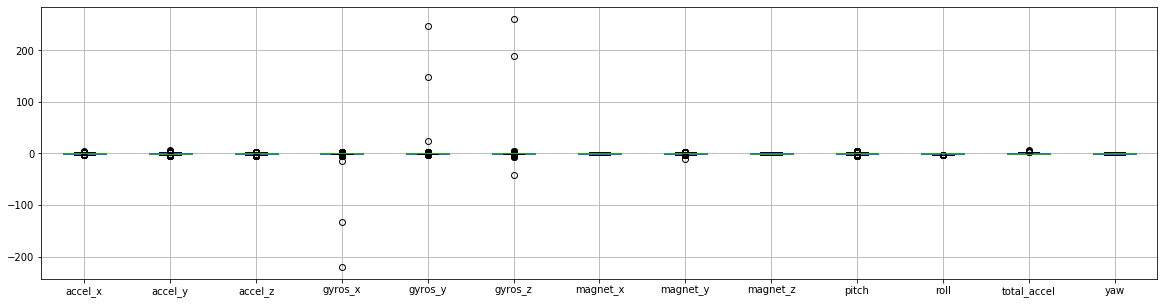

In [174]:
plt.figure(figsize=(20,5))
x.boxplot()

In [191]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                         'principal component 3'])

In [186]:
# Fit the isolation Forest
clf = IsolationForest(random_state=0).fit(x)
# Make the predictions
predictions_if=clf.predict(x)
sum(predictions_if==-1)/len(predictions_if)

0.152390660338292

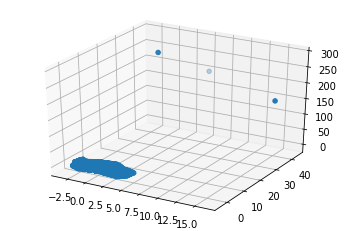

In [197]:
#plt.plot(principalDf['principal component 1'],principalDf['principal component 2'],'.')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(principalDf['principal component 1'], 
          principalDf['principal component 2'], 
          principalDf['principal component 3'], 'gray')

In [198]:
pca.explained_variance_ratio_

array([0.18824751, 0.1498177 , 0.13602933])

In [199]:
# Fit the isolation Forest
clf = IsolationForest(random_state=0).fit(x)
# Make the predictions
predictions_if=clf.predict(x)
sum(predictions_if==-1)/len(predictions_if)

0.152390660338292

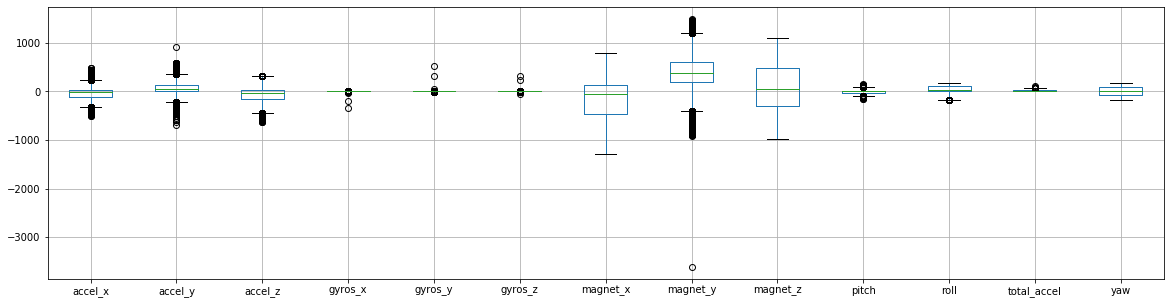

In [155]:
plt.figure(figsize=(20,5))
numerical_tidy_X_train.boxplot()

In [156]:
# Fit the isolation Forest
clf = IsolationForest(random_state=0).fit(numerical_tidy_X_train)
# Make the predictions
predictions_if=clf.predict(numerical_tidy_X_train)
sum(predictions_if==-1)/len(predictions_if)

0.152390660338292

In [158]:
# Compute the outliers with univariate IQR method
from functions import iqr_rule 
predictions_iqr = numerical_tidy_X_train.apply(iqr_rule,axis=0).all(axis=1)

In [159]:
sum(predictions_iqr)/len(predictions_iqr)

0.5692590704934221

### Training and Validation Dataset
<a id='Training_and_Validation_Dataset'></a>



## Feature Selection/Importance
<a id='Feature_Selection_Importance'></a>
* Remember the scale of the variables!!!!     
https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]

In [ ]:
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
importance

## Classification Model
<a id='Classification_Model'></a>

## Conclusions and Remarks
<a id='Conclusions_and_Remarks'></a>